# 🏡 House Price Prediction with LightGBM + KMeans Location Clustering

This notebook improves the previous pipeline by adding KMeans clustering on `lat` and `lon` to create a `location_cluster` feature.

Models:
- **Lower bound**: LightGBM quantile regression (alpha = 0.1)
- **Upper bound**: LightGBM quantile regression (alpha = 0.9)
- **Point prediction**: FLAML AutoML

Final submission: `ID,LOWER,UPPER,PRED`.

In [1]:
# 📦 Install required packages
!pip install flaml lightgbm scikit-learn pandas

In [1]:
# Imports
import pandas as pd
import lightgbm as lgb
from flaml import AutoML
from sklearn.cluster import KMeans
from sklearn.impute import KNNImputer

c:\Users\fabri\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load data
train = pd.read_csv("Data/train.csv")
test = pd.read_csv("Data/test.csv")

In [3]:
# Clean and simplify energy columns
def fix_energy_columns(df):
    df["energy_value"] = df["energy_value"].fillna(df.groupby("energy_label")["energy_value"].transform("median"))
    df["energy_value"] = df["energy_value"].fillna(df.groupby("bedrooms")["energy_value"].transform("median"))
    df["energy_value"] = df["energy_value"].fillna(250)

    bins = [-100, 0, 100, 200, 300, 400, 500, 1000]
    labels = ['a+', 'a', 'b', 'c', 'd', 'e', 'f']
    df["energy_label"] = df["energy_label"].fillna(
        pd.cut(df["energy_value"], bins=bins, labels=labels, right=True)
    )
    df["energy_label"] = df["energy_label"].fillna("c")
    df["energy_label"] = df["energy_label"].map(lambda x: x.rstrip("+") if isinstance(x, str) else x)
    return df

# Simplify the property subtypes
def reduce_subtypes(df):
    subtype_map = {
        'Appartement': 'Apartment', 'Duplex': 'Apartment', 'Gelijkvloers app.': 'Apartment',
        'Penthouse': 'High-End Apartment', 'Loft': 'High-End Apartment', 'Triplex': 'High-End Apartment',
        'Villa': 'Luxury Home', 'Herenhuis': 'Luxury Home', 'Pastorijwoning': 'Luxury Home',
        'Hoeve': 'Rural Home', 'Fermette': 'Rural Home', 'Boerderij': 'Rural Home',
        'Bungalow': 'Vacation Home', 'Vakantiewoning': 'Vacation Home',
        'Gemengd gebruik': 'Other', 'Andere': 'Other'
    }
    df["subtype"] = df["subtype"].map(lambda x: subtype_map.get(x, "General"))
    return df

# ✅ Apply to train and test
train = fix_energy_columns(train)
test = fix_energy_columns(test)
train = reduce_subtypes(train)
test = reduce_subtypes(test)

In [4]:
# KNN imputation for lat/lon
imputer = KNNImputer(n_neighbors=5)
train[["lat", "lon"]] = imputer.fit_transform(train[["lat", "lon"]])
test[["lat", "lon"]] = imputer.transform(test[["lat", "lon"]])

# KMeans clustering on lat/lon to create 'location_cluster'
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(train[["lat", "lon"]])
train["location_cluster"] = kmeans.predict(train[["lat", "lon"]])
test["location_cluster"] = kmeans.predict(test[["lat", "lon"]])

In [5]:
# Preprocessing and feature setup
cat_cols = ['province', 'energy_lab', 'advertiser', 'subtype', 'sticker', 'location_cluster']
for col in cat_cols:
    for df in [train, test]:
        if col in df.columns:
            df[col] = df[col].astype("category")

X = train.drop(columns=["id", "price"])
y = train["price"]
X_test = test.drop(columns=["id"])

for col in X.columns:
    if X[col].dtype == "object":
        X[col] = X[col].astype("category")

for col in X_test.columns:
    if X_test[col].dtype == "object":
        X_test[col] = X_test[col].astype("category")

In [6]:
# Lower bound model (10th percentile)
model_lower = lgb.LGBMRegressor(objective='quantile', alpha=0.1)
model_lower.fit(X, y)
pred_lower = model_lower.predict(X_test)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 27071, number of used features: 17
[LightGBM] [Info] Start training from score 178500.015625


In [7]:
# Upper bound model (90th percentile)
model_upper = lgb.LGBMRegressor(objective='quantile', alpha=0.9)
model_upper.fit(X, y)
pred_upper = model_upper.predict(X_test)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3228
[LightGBM] [Info] Number of data points in the train set: 27071, number of used features: 17
[LightGBM] [Info] Start training from score 615000.000000


In [8]:
# Point prediction using FLAML
automl = AutoML()
automl.fit(X_train=X, y_train=y, task='regression', metric="mae", time_budget=1800)
pred_point = automl.predict(X_test)

print("Best FLAML model:", automl.best_estimator)
print("Best config:", automl.best_config)
print("Best validation loss:", automl.best_loss)

from sklearn.metrics import mean_absolute_error

val_preds = automl.predict(X_val)
mae_val = mean_absolute_error(y_val, val_preds)
print("MAE on validation set:", mae_val)

[flaml.automl.logger: 04-10 17:26:23] {1728} INFO - task = regression
[flaml.automl.logger: 04-10 17:26:23] {1739} INFO - Evaluation method: cv
[flaml.automl.logger: 04-10 17:26:23] {1838} INFO - Minimizing error metric: mae
[flaml.automl.logger: 04-10 17:26:23] {1955} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'sgd']
[flaml.automl.logger: 04-10 17:26:23] {2258} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 04-10 17:26:24] {2393} INFO - Estimated sufficient time budget=4195s. Estimated necessary time budget=30s.
[flaml.automl.logger: 04-10 17:26:24] {2442} INFO -  at 0.5s,	estimator lgbm's best error=122389.7755,	best estimator lgbm's best error=122389.7755
[flaml.automl.logger: 04-10 17:26:24] {2258} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 04-10 17:26:24] {2442} INFO -  at 1.0s,	estimator lgbm's best error=122389.7755,	best estimator lgbm's best error=122389.7755
[flaml.automl.logger: 04-1

NameError: name 'X_val' is not defined

In [9]:
# 📄 Final submission: ID, LOWER, UPPER, PRED
submission = pd.DataFrame({
    "ID": test["id"],
    "LOWER": pred_lower,
    "UPPER": pred_upper,
    "PRED": pred_point
})

# Clamp PRED inside bounds
submission["LOWER"] = submission[["LOWER", "UPPER"]].min(axis=1)
submission["UPPER"] = submission[["LOWER", "UPPER"]].max(axis=1)
submission["PRED"] = submission[["PRED", "LOWER"]].max(axis=1)
submission["PRED"] = submission[["PRED", "UPPER"]].min(axis=1)

# Export CSV without header for submission
submission.to_csv("automl_submission_3.csv", index=False, header=False)
submission.head()

,ID,LOWER,UPPER,PRED
0,te0,324070.792524,717795.227914,415729.062500
1,te1,314144.835381,538751.250647,392636.500000
2,te2,152912.053399,235243.370529,235243.370529
3,te3,135901.798355,231877.223700,184598.968750
4,te4,341192.315151,429827.807079,341192.315151


Best estimator: xgboost
Best configuration found by FLAML:
  n_estimators: 1137
  max_leaves: 470
  min_child_weight: 10.46191002079224
  learning_rate: 0.026815059544605373
  subsample: 0.827351358517848
  colsample_bylevel: 0.2838655864739324
  colsample_bytree: 0.527521760359795
  reg_alpha: 0.0009765625
  reg_lambda: 8.422224212554422


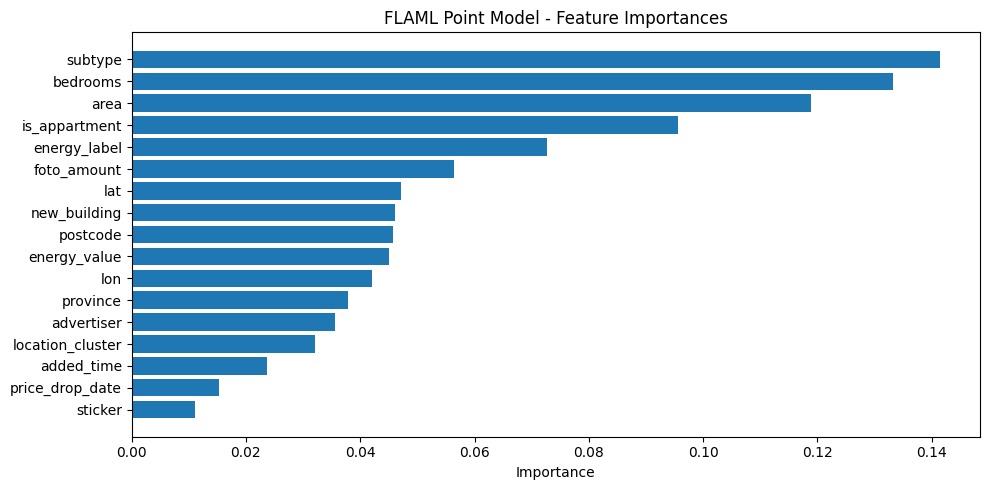

In [ ]:
# 📌 Inspect FLAML point prediction model
print("Best estimator:", automl.best_estimator)
print("Best configuration found by FLAML:")
for key, val in automl.best_config.items():
    print(f"  {key}: {val}")

# 📊 Plot feature importances, if supported
try:
    import pandas as pd
    import matplotlib.pyplot as plt

    importances = automl.model.feature_importances_
    feat_df = pd.DataFrame({
        "feature": automl.feature_names_in_,  # aligns with model input
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    plt.figure(figsize=(10, 5))
    plt.barh(feat_df["feature"], feat_df["importance"])
    plt.title("FLAML Point Model - Feature Importances")
    plt.xlabel("Importance")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

except AttributeError:
    print("⚠️ Feature importances not available for this model.")